In [1]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

[nltk_data] Downloading package punkt to /home/pedrox/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pedrox/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/pedrox/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
!pip install pandas
import pandas as pd
df = pd.read_csv('./data_cleaning.csv',sep=';')
#df = df.drop(columns=['index'])
df["ncm"] = df["ncm"].astype(str)
for i in range(len(df)):
  if len(df["ncm"].iloc[i]) < 8:
    df["ncm"].iloc[i] = "0"+ df["ncm"].iloc[i]
df['ncm_in'] = df['ncm'].astype(str).str[:2]
df['ncm_out'] = df['ncm'].astype(str).str[2:4]
df = df.drop(columns=['Unnamed: 0','ncm'])

df = df.dropna()

/home/pedrox/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='ncm_out'>

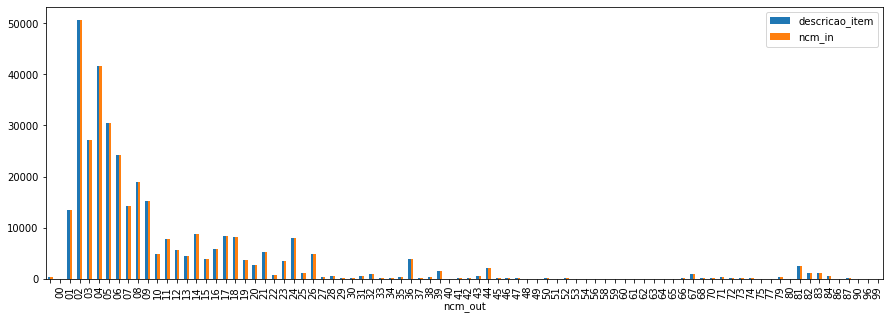

In [3]:
!pip install matplotlib
import matplotlib.pyplot as plt
df_group = df.groupby('ncm_out').count()
df_group
df_group.plot.bar( figsize=(15, 5))

In [4]:
over5000 = []
median = []
less1000 = []

for i in range(len(df_group)):
    if df_group['descricao_item'].iloc[i] > 5000:
        over5000.append(df_group['descricao_item'].index[i])
    elif df_group['descricao_item'].iloc[i] < 1000:
        less1000.append(df_group['descricao_item'].index[i])
    else:
        median.append(df_group['descricao_item'].index[i])

In [5]:
print(f"acima de 5000 amostras {len(over5000)}\nentre 5000 e 1000 {len(median)}\nabaixo de 1000 {len(less1000)}")


acima de 5000 amostras 17
entre 5000 e 1000 14
abaixo de 1000 55


In [6]:
len(df)

343240

In [7]:
#DROP menores que 1000
for i in less1000:
   df.drop(df.loc[df['ncm_out'] == i].index, inplace=True)

In [8]:
len(df)

334651

In [9]:
import pandas as pd
import numpy as np


for i in over5000: 
    remove_n = len(df.loc[df['ncm_out'] == i ]) - 5000
    remove_class = i
    # Here you first find the indexes where class is equal to the class you want to drop.
    #Then you slice only the first n indexes of this class
    index_to_drop = df.index[df['ncm_out'] == remove_class][:remove_n]
    #Finally drop those indexes
    df = df.drop(index_to_drop)

In [10]:
df = df.reset_index()
df

,index,descricao_item,ncm_in,ncm_out
0,16,OIL E7 15W GRANEL DEP,27,10
1,23,CS K BB CS TINTA 2L PRETA,32,15
2,41,GINKGO VITAL MG CPS SIM GINKGO BILOBA,39,23
3,78,CONECTOR XLR LINHA P MACHO NIQ,85,36
4,166,CONECTOR XLR LINHA P FEMEA NIQ,85,36
...,...,...,...,...
125835,343242,ZIN E MAQUINA DO VIDRO ESQUERDA PINO ALTO,87,08
125836,343243,"ZINCO 100CM 3,50KG P MT CP",72,10
125837,343244,ZMM 9010811 ALTERNADOR 12V AMP,85,11
125838,343245,ZORDS COM FIGURA E,95,03


In [11]:
df = df.drop(columns=['index',])

<AxesSubplot:xlabel='ncm_out'>

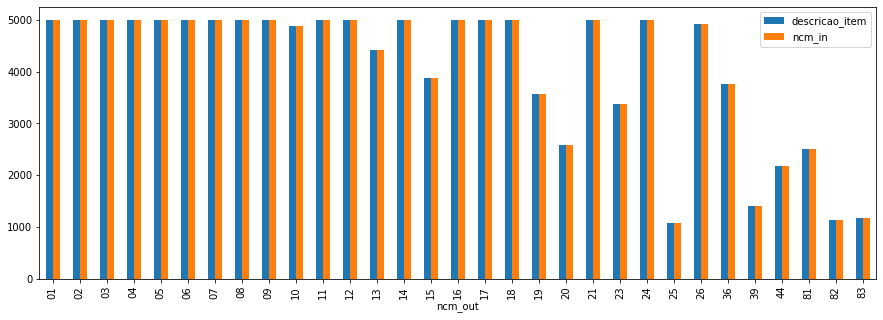

In [12]:
df_group_nw = df.groupby('ncm_out').count()
df_group_nw
df_group_nw.plot.bar( figsize=(15, 5))

In [13]:
palavras_final = []
for i in range(len(df['descricao_item'])): 
    produto = df['descricao_item'].iloc[i]
    from string import punctuation
    sentencas = nltk.sent_tokenize(produto)
    palavras = nltk.word_tokenize(produto.upper())
    stemmer = nltk.stem.RSLPStemmer()
    palavras_stem = []
    for palavra in palavras:
        palavras_stem.append(stemmer.stem(palavra))
    palavras_sem_stopwords = [palavras_stem for palavras_stem in palavras_stem if palavras_stem not in stopwords]
    palavra_final = ' '.join(palavras_sem_stopwords)
    palavras_final.append(palavra_final)
x = pd.Series(palavras_final)
df['descricao_item_clean'] = x

In [14]:
df.dropna()

,descricao_item,ncm_in,ncm_out,descricao_item_clean
0,OIL E7 15W GRANEL DEP,27,10,oil e7 15w granel dep
1,CS K BB CS TINTA 2L PRETA,32,15,cs k bb cs tint 2l pret
2,GINKGO VITAL MG CPS SIM GINKGO BILOBA,39,23,ginkg vital mg cp sim ginkg bilob
3,CONECTOR XLR LINHA P MACHO NIQ,85,36,conec xlr linh p mach niq
4,CONECTOR XLR LINHA P FEMEA NIQ,85,36,conec xlr linh p feme niq
...,...,...,...,...
125835,ZIN E MAQUINA DO VIDRO ESQUERDA PINO ALTO,87,08,zin maquin vidr esquerd pin alt
125836,"ZINCO 100CM 3,50KG P MT CP",72,10,"zinc 100cm 3,50kg p mt cp"
125837,ZMM 9010811 ALTERNADOR 12V AMP,85,11,zmm 9010811 altern 12v amp
125838,ZORDS COM FIGURA E,95,03,zord figur


In [15]:
data = [df["descricao_item_clean"], df["ncm_in"]]

headers = ["descricao", "ncm_in"]

df_n = pd.concat(data, axis=1, keys=headers)


In [16]:
!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

labels = df['ncm_out']
text = df_n

X_train, X_test, y_train, y_test = train_test_split(text, labels, random_state=0, test_size=0.2)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.descricao)
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_transformed = tf_transformer.transform(X_train_counts)

X_test_counts = count_vect.transform(X_test.descricao)
X_test_transformed = tf_transformer.transform(X_test_counts)

labels_enc = LabelEncoder()
y_train_labels_fit = labels_enc.fit(y_train)
y_train_lables_trf = labels_enc.transform(y_train)

#print(labels.classes_)

In [17]:
import scipy.sparse as sp
X_position_train = np.atleast_2d(X_train.ncm_in.astype(int)).T
X_train = sp.hstack((X_train_transformed, X_position_train))

X_position_test = np.atleast_2d(X_test.ncm_in.astype(int)).T
X_test = sp.hstack((X_test_transformed, X_position_test))

In [18]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
clf = linear_svc.fit(X_train,y_train)

/home/pedrox/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [39]:
from sklearn import metrics
import numpy as np
y_test = y_test.astype(int)
#p_count = count_vect.transform(list(X_test))
#p_tfidf = tf_transformer.transform(p_count)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

/home/pedrox/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pedrox/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pedrox/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pedrox/.local/lib/python3.9/site-packages/

              precision    recall  f1-score   support

          01       0.00      0.00      0.00         0
          02       0.00      0.00      0.00         0
          03       0.00      0.00      0.00         0
          04       0.00      0.00      0.00         0
          05       0.00      0.00      0.00         0
          06       0.00      0.00      0.00         0
          07       0.00      0.00      0.00         0
          08       0.00      0.00      0.00         0
          09       0.00      0.00      0.00         0
           1       0.00      0.00      0.00       977
          10       0.85      0.77      0.81       964
          11       0.84      0.71      0.77      1025
          12       0.18      0.94      0.30       976
          13       0.83      0.65      0.73       901
          14       0.80      0.66      0.72      1049
          15       0.88      0.64      0.74       739
          16       0.83      0.60      0.69       995
          17       0.84    

/home/pedrox/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pedrox/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print(len(list(y_test)))
print(len(y_pred))

25168
25168


In [ ]:
len(set(y_test) - set(y_pred))

22

In [ ]:
from sklearn.metrics import f1_score
metrics.f1_score(y_test, y_pred,average='weighted', labels=np.unique(y_pred))

0.005327608073172032

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='weighted', labels=np.unique(y_pred))

(0.00542978368204709, 0.005750109811124865, 0.005327608073172032, None)

In [ ]:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

SyntaxError: invalid syntax (1279775754.py, line 1)